In [1]:
# Initial setup
import RNA # pip3 install viennarna # conda install bioconda::viennarna did not work
from Bio.SeqUtils import MeltingTemp as mt # pip3 install biopython
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
from collections import Counter
from IPython.display import HTML

# Load DNA parameters
RNA.params_load_DNA_Mathews2004()

# Change some jupyter display options
pd.set_option("display.max_rows", 100)     # default is 60
pd.set_option("display.max_columns", 50)  # default is 20
pd.set_option("display.width", 1000)  
pd.set_option("display.expand_frame_repr", False)  # Keeps table in one block

In [2]:
### Library functions ###
def reverse_complement(seq: str) -> str:
    """
    Return the reverse complement of a DNA sequence (5'→3').

    Parameters
    ----------
    seq : str
        DNA sequence (A, T, G, C).

    Returns
    -------
    str
        Reverse complement sequence (5'→3').
    """
    complement = str.maketrans("ATGCatgc", "TACGtacg")
    return seq.translate(complement)[::-1]

def score_primers(primer_pairs_df, weights, tm_opt=55, length_opt=20, product_opt=2500):
    """
    Compute and attach a total score to each primer pair.
    Returns the input DataFrame with one new column: 'Score',
    sorted from best (closest to 0) to worst.
    """

    # --- Helper sub-scores ---
    def gc_clamp_score(seq):
        end = seq[-3:].upper()
        gc_count = sum(b in "GC" for b in end)
        if gc_count == 3:
            return -1
        elif gc_count == 2:
            return 0
        elif gc_count == 1:
            return -0.5
        else:
            return -3

    def gc_deviation(seq):
        gc = (seq.count("G") + seq.count("C")) / len(seq) * 100
        return -abs(gc - 50) / 10  # scaled penalty

    def tm_deviation(tm_f, tm_r):
        tm_avg = (tm_f + tm_r) / 2
        return -abs(tm_avg - tm_opt) / 2
    
    def len_deviation(seq):
        return -abs(len(seq) - length_opt)

    def product_size_score(size):
        return -abs(size - product_opt) / product_opt * 10  # penalty as percentage

    def mfe_score(row):
        """Return combined MFE score based on the weakest (most negative) structures for each type."""
        def safe_min(values):
            vals = [v for v in values if pd.notna(v)]
            return min(vals) if vals else 0

        # Forward
        f_mfe_min = safe_min([row["Forward_MFE"], row["F_MFE_adapted"]])
        f_homo_min = safe_min([row["Forward_homodimer_MFE"], row["F_homodimer_MFE_adapted"]])
        # Reverse
        r_mfe_min = safe_min([row["Reverse_MFE"], row["R_MFE_adapted"]])
        r_homo_min = safe_min([row["Reverse_homodimer_MFE"], row["R_homodimer_MFE_adapted"]])
        # Heterodimer
        het_min = safe_min([row["Het_MFE"], row["Het_MFE_adapted"]])

        # Weighted combination (heterodimer has double weight)
        w_mfe_score = np.sum([f_mfe_min, f_homo_min, r_mfe_min, r_homo_min, het_min])
        return w_mfe_score

    # --- Compute total score ---
    df = primer_pairs_df.copy()
    df["Score"] = (
        ((df["Forward_seq"].apply(gc_clamp_score) + df["Reverse_seq"].apply(gc_clamp_score)) / 2) * weights["gc_clamp"]
        + ((df["Forward_seq"].apply(gc_deviation) + df["Reverse_seq"].apply(gc_deviation)) / 2) * weights["gc_dev"]
        + df.apply(lambda r: tm_deviation(r["Forward_Tm"], r["Reverse_Tm"]), axis=1) * weights["tm_dev"]
        + df.apply(mfe_score, axis=1) * weights["mfe"]
        + df["Product size"].apply(product_size_score) * weights["product"]
        + df["Forward_seq"].apply(len_deviation) * weights["length"]
        + df["Reverse_seq"].apply(len_deviation) * weights["length"]
    )

    # --- Sort by best score (closer to 0 is better) ---
    df = df.sort_values("Score", ascending=False).reset_index(drop=True)

    # Return only input columns + final score
    return df

def remove_overlapping_primers(df, buffer=0):
    """
    Remove overlapping primer pairs (both forward and reverse sides).
    Keeps the best (highest Score) representative of overlapping regions.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain 'Forward_start', 'Forward_end', 'Reverse_start', 'Reverse_end', and 'Score' columns.
    buffer : int, optional
        Extra allowed spacing (in bp) between primers considered overlapping. Default 0.

    Returns
    -------
    pd.DataFrame
        Filtered DataFrame with non-overlapping primer pairs.
    """

    # Sort by score (best first)
    df_sorted = df.sort_values("Score", ascending=False).reset_index(drop=True)

    kept = []
    f_used = []  # list of (start, end) tuples for forward primers
    r_used = []  # list of (start, end) tuples for reverse primers

    for _, row in df_sorted.iterrows():
        f_start, f_end = row["Forward_start"], row["Forward_end"]
        r_start, r_end = row["Reverse_start"], row["Reverse_end"]

        # Check if overlaps with any previously accepted forward or reverse
        f_overlap = any(
            not (f_end + buffer < s or f_start - buffer > e) for s, e in f_used
        )
        r_overlap = any(
            not (r_end + buffer < s or r_start - buffer > e) for s, e in r_used
        )

        # Keep only if no overlap detected
        if not f_overlap and not r_overlap:
            kept.append(row)
            f_used.append((f_start, f_end))
            r_used.append((r_start, r_end))

    return pd.DataFrame(kept).reset_index(drop=True)

def dimer_min_mfe(seq1, seq2 = None, silent = True):
    if seq2 == None: seq2 = seq1
    # --- Configurations ---
    configs = [
        (seq1, seq2, "Original"),
        (seq1[::-1], seq2, "First reversed"),
        (seq1, seq2[::-1], "Second reversed"),
        (seq1[::-1], seq2[::-1], "Both reversed")
    ]

    # loop through configurations
    # set min MFE
    min_mfe = float('inf')
    min_config = ''
    for (s1, s2, label) in configs:
        dimer_seq = s1 + "&" + s2
        # Fold dimer
        _, mfe = RNA.fold(dimer_seq)
        # check mfe
        if mfe < min_mfe:
            # Save min mfe
            min_mfe = mfe
            # Save label
            min_config = label
    if not silent:
        print(f"Lowest MFE: {min_mfe:.2f} kcal/mol ({min_config})")
    # filter for absurdly large values
    if min_mfe > 0: min_mfe = 0
    return(min_mfe)

# Helper to generate muted colors for plotting
def mute_color(color, factor=0.95):
    r, g, b = mcolors.to_rgb(color)
    return (
        #r * (1 - factor) + 0.5 * factor,
        r,
        g * (1 - factor) + 0.5 * factor,
        b * (1 - factor) + 0.5 * factor,
    )


def plot_dimer(seq1, seq2=None, labels=None, scale=1.0):
    if seq2 is None: seq2 = seq1
    if labels is None:
        labels = ["F primer", "R primer"]
    if seq1 == seq2: labels = [labels[0], labels[0]+" (copy)"]
    # --- Detect if sequences contain lowercase letters (adapters) ---
    has_adapter1 = any(c.islower() for c in seq1)
    has_adapter2 = any(c.islower() for c in seq2)

    configs = [
        (seq1, seq2, "Original"),
        (seq1[::-1], seq2, "First reversed"),
        (seq1, seq2[::-1], "Second reversed"),
        (seq1[::-1], seq2[::-1], "Both reversed"),
    ]

    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    fig.patch.set_facecolor("#212121ff")  # dark background
    strand_colors = ["#4C72B0", "#DD8452"]  # soft blue & orange
    adapter_colors = [mute_color(strand_colors[0]), mute_color(strand_colors[1])]

    for ax, (s1, s2, label) in zip(axes.flat, configs):
        dimer_seq = s1 + "&" + s2
        ss, mfe = RNA.fold(dimer_seq)

        coords = RNA.naview_xy_coordinates(ss)[:-1]
        # Scale base coordinates
        x = [scale * c.X for c in coords]
        y = [scale * c.Y for c in coords]

        seq_no_amp = dimer_seq.replace("&", "")
        L = len(s1)

        # --- Parse base pairs from dot-bracket ---
        stack = []
        pairs = {}
        for i, ch in enumerate(ss.replace("&", "")):
            if ch == "(":
                stack.append(i)
            elif ch == ")":
                j = stack.pop()
                pairs[i] = j
                pairs[j] = i

        #ax.set_aspect("equal")

        # --- Draw base-pair bonds ---
        for i, j in pairs.items():
            if i < j:
                ax.plot([x[i], x[j]], [y[i], y[j]], color="1.0", lw=1.6, zorder=1)

        # --- Draw nucleotides with adapter detection ---
        for i, (xi, yi) in enumerate(zip(x, y)):
            base = seq_no_amp[i]
            strand_idx = 0 if i < L else 1

            # Decide color: normal strand or muted adapter
            if base.islower():
                color = adapter_colors[strand_idx]
            else:
                color = strand_colors[strand_idx]

            ax.scatter(xi, yi, s=120, color=color, edgecolor="gray", linewidth=1, zorder=2)
            ax.text(xi, yi, base, ha="center", va="center",
                    fontsize=7, color="white", weight="bold", zorder=3)

        ax.set_title(f"{label}\nMFE = {mfe:.2f} kcal/mol",
                     fontsize=11, pad=10, color='white')

        # --- Fix axis limits to respect scaling ---
        xmin, xmax = min(x), max(x)
        ymin, ymax = min(y), max(y)
        R = max(xmax - xmin, ymax - ymin) / 2
        xc = (xmax + xmin) / 2
        yc = (ymax + ymin) / 2
        pad = 0.15 * R
        ax.set_xlim(xc - R - pad, xc + R + pad)
        ax.set_ylim(yc - R - pad, yc + R + pad)
        ax.axis("off")

    # --- Build legend dynamically ---
    handles = []

    # Strand legend entries
    handles.append(
        plt.Line2D([], [], marker="o", color="none",
                markerfacecolor=strand_colors[0], markersize=10,
                label=labels[0])
    )
    handles.append(
        plt.Line2D([], [], marker="o", color="none",
                markerfacecolor=strand_colors[1], markersize=10,
                label=labels[1])
    )

    # Optional adapter legend entries
    if has_adapter1:
        handles.append(
            plt.Line2D([], [], marker="o", color="none",
                    markerfacecolor=adapter_colors[0], markersize=10,
                    label=f"{labels[0]} adapter")
        )

    if has_adapter2:
        handles.append(
            plt.Line2D([], [], marker="o", color="none",
                    markerfacecolor=adapter_colors[1], markersize=10,
                    label=f"{labels[1]} adapter")
        )

    legend = fig.legend(
        handles=handles,
        loc="upper center",
        ncol=len(handles),
        frameon=False,
    )
    plt.setp(legend.get_texts(), color="white")

def plot_linear(seq1, seq2=None, labels=None,strand_colors=None, adapter_color_factor=0.95, figsize=(12, 2)):
    """
    Plot sequences as straight horizontal lines with colored nucleotides.

    Parameters
    ----------
    seq1 : str
        First sequence
    seq2 : str, optional
        Second sequence (default None → only seq1)
    labels : list of 2 str, optional
    strand_colors : list of 2 colors, optional
        Colors for strand 1 and 2. Defaults to ['#4C72B0', '#DD8452']
    adapter_factor : float
        Factor to mute lowercase letters (adapters)
    figsize : tuple
        Figure size
    """
    if labels is None:
        labels = ["F Primer", "R Primer"]
    if strand_colors is None:
        strand_colors = ['#4C72B0', '#DD8452']

    adapter_colors = [mute_color(c, adapter_color_factor) for c in strand_colors]

    if seq2 is None:
        sequences = [(seq1, strand_colors[0], adapter_colors[0])]
        labels = [labels[0]]
    else:
        sequences = [(seq1, strand_colors[0], adapter_colors[0]),
                     (seq2, strand_colors[1], adapter_colors[1])]

    fig, ax = plt.subplots(figsize=figsize)
    fig.patch.set_facecolor("#212121ff")  # dark background

    y_spacing = 1.0  # vertical distance between strands
    for i, (seq, color, adapter_color) in enumerate(sequences):
        y = (len(sequences) - 1 - i) * y_spacing
        x_positions = range(len(seq))
        for xi, base in zip(x_positions, seq):
            base_color = adapter_color if base.islower() else color
            ax.scatter(xi, y, s=200, color=base_color, edgecolor='gray', zorder=2)
            ax.text(xi, y, base, ha='center', va='center', color='white', weight='bold', fontsize=10, zorder=3)

        # Draw straight line connecting the bases
        ax.plot(range(len(seq)), [y]*len(seq), color='0.7', lw=2, zorder=1)

        ax.set_ylim(-0.5, len(sequences)-0.5)
        ax.set_xlim(-1, max(len(seq1), len(seq2)))
        ax.axis('off')
        ax.text(
        -1.2, y,
        labels[i],
        ha="right",
        va="center",
        fontsize=11,
        color="white",
        weight="bold",
    )
    plt.show()


def find_subsequence_coordinates(subseq, sequence, silent=False):
    """
    Search for a subsequence (DNA) within a longer sequence.
    If not found, try reverse complement and report accordingly.

    Parameters
    ----------
    subseq : str
        The DNA subsequence to search for (e.g. 'ATGCGT').
    sequence : str
        The longer DNA sequence to search within.
    silent : bool, optional
        If True, suppresses printed output. Default = False.

    Returns
    -------
    tuple
        (start, end, reverse_complemented)
        - start: 1-based start position in `sequence`
        - end: 1-based end position in `sequence`
        - reverse_complemented: True if subseq was reverse complemented to find a match
        Returns (None, None, False) if no match found.
    """
    subseq = subseq.upper()
    sequence = sequence.upper()

    # Try direct match
    idx = sequence.find(subseq)
    if idx != -1:
        start = idx + 1  # 1-based indexing
        end = start + len(subseq) - 1
        if not silent:
            print(f"✅ Found subsequence at {start}-{end} (forward strand).")
        return start, end, False

    # Try reverse complement
    rc_subseq = reverse_complement(subseq)
    idx_rc = sequence.find(rc_subseq)
    if idx_rc != -1:
        start = idx_rc + 1
        end = start + len(subseq) - 1
        if not silent:
            print(f"⚠️ Subsequence not found directly — found reverse complement at {start}-{end}.")
        return start, end, True

    # Not found
    if not silent:
        print("❌ Subsequence not found in either orientation.")
    return None, None, False

def map_coordinates_to_reverse(start, end, seq_length):
    """
    Convert coordinates (start, end) from the forward strand
    to their corresponding positions on the reverse complement strand.

    Parameters
    ----------
    start : int
        1-based start position on the forward strand.
    end : int
        1-based end position on the forward strand.
    seq_length : int
        Total length of the sequence.

    Returns
    -------
    tuple
        (rev_start, rev_end)
        Coordinates (1-based) corresponding to the same region on the reverse complement.

    Example
    -------
    >>> map_coordinates_to_reverse(10, 20, 100)
    (81, 91)
    """
    if start < 1 or end > seq_length or start > end:
        raise ValueError("Invalid coordinates: must be 1-based and within sequence length.")

    rev_start = seq_length - end + 1
    rev_end = seq_length - start + 1

    return rev_start, rev_end

def template_adapter_overlap(seq1, seq2):
    # Make case sensitive
    seq1 = seq1.upper()
    seq2 = seq2.upper()

    overlap = ''
    # Start from end and move backwards
    for i in range(1, min(len(seq1), len(seq2)) + 1):
        if seq1[-i:] == seq2[-i:]:
            overlap = seq1[-i:]
        else:
            break
    return overlap

def get_score_weights():
    weights = {
    "gc_clamp": 1.0,
    "gc_dev": 0.5,
    "tm_dev": 1.0,
    "mfe": 1.0,
    "product": 0.1,
    "length": 2
}
    return weights

def analyze_primer(primer_seq, adapter_seq = '', id_str = '', seq_start = np.nan, seq_end = np.nan, end_window = 5, return_dict = False, CONSTRAINTS = None, insert_tm = None):

    # Checking 3'-end
    three_end = primer_seq[-end_window:] # 3' end length
    three_gc_ending = sum(1 for b in three_end[-1:] if b in "GC") # 1/0 if ends in C or G
    three_gc_ratio = (three_end.count("G") + three_end.count("C")) / len(three_end) # calculate C/G ratio in 3' end
    if CONSTRAINTS:
        if three_gc_ending < CONSTRAINTS["end_in_GC"]: return None

    # Adapter concatenation to 5' end
    seq_adapted = adapter_seq + primer_seq

    # GC content
    gc = (primer_seq.count("G") + primer_seq.count("C")) / len(primer_seq) * 100

    # Tm or melting temperature 
    if insert_tm: tm = insert_tm
    else: tm = mt.Tm_NN(primer_seq, nn_table=mt.DNA_NN4)
    if CONSTRAINTS:
        if tm < CONSTRAINTS["tm_threshold"]: return None

    # Structure MFEs
    _, mfe = RNA.fold(primer_seq)
    if CONSTRAINTS:
        if mfe < CONSTRAINTS["mfe_threshold"]: return None
    _, mfe_a = RNA.fold(seq_adapted)
    if CONSTRAINTS:
        if mfe_a < CONSTRAINTS["adapted_mfe_threshold"]: return None

    # Homodimer MFEs
    hom_mfe = dimer_min_mfe(primer_seq)
    if CONSTRAINTS:
        if hom_mfe < CONSTRAINTS["mfe_threshold"]: return None
    hom_mfe_a = dimer_min_mfe(seq_adapted)
    if CONSTRAINTS:
        if hom_mfe_a < CONSTRAINTS["adapted_mfe_threshold"]: return None

    # Fix absurdly large values
    if mfe > 0: mfe = 0
    if mfe_a > 0: mfe_a = 0
    if hom_mfe > 0: hom_mfe = 0
    if hom_mfe_a > 0: hom_mfe_a = 0

    seq_stats = {id_str+"start": seq_start,
                 id_str+"end": seq_end,
                 id_str+"length": len(primer_seq),
                 id_str+"seq": primer_seq,
                 id_str+"GC%": gc,
                 id_str+"3-GC_ratio": three_gc_ratio,
                 id_str+"3-GC_end": three_gc_ending,
                 id_str+"Tm": tm,
                 id_str+"MFE": mfe,
                 id_str+"Homodimer_MFE": hom_mfe,
                 id_str+"seq_adapted": seq_adapted,
                 id_str+"MFE_adapted": mfe_a,
                 id_str+"Homodimer_MFE_adapted": hom_mfe_a}
    # If not specified otherwise, return as dict
    if return_dict: return seq_stats
    # Convert dictionary to DataFrame and return
    seq_stats = pd.DataFrame([seq_stats])
    return seq_stats

def find_primers(
    seq,
    search_region = (1,None),
    min_window=20,
    max_window=30,
    end_window=5,
    step=1,
    tm_threshold=55,
    adapter_seq='',
    id_str='',
    return_reverse_coordinates=False,
    CONSTRAINTS=None
):
    """
    Adaptive sliding-window analysis of a DNA sequence.
    Window length grows until Tm >= threshold or max_window is reached.

    Parameters
    ----------
    seq : str
        Input DNA sequence (5'->3').
    min_window : int
        Minimum window size (default: 20).
    max_window : int
        Maximum window size to test (default: 30).
    step : int
        Step between consecutive windows (default: 1).
    tm_threshold : float
        Minimum Tm threshold; window will expand until Tm >= threshold.

    Returns
    -------
    pandas.DataFrame
        Columns:
        start, end, subseq, GC%, Tm, MFE, MFE_adapted,
        Homodimer_MFE, Homodimer_MFE_adapted
    """
    # override values if CONSTRAINTS is not None
    if CONSTRAINTS:
        min_window = CONSTRAINTS["min_length"]
        max_window = CONSTRAINTS["max_length"]
        tm_threshold = CONSTRAINTS["tm_threshold"]
        
    results = []
    true_n = len(seq)

    # Take subregion of the sequence
    if search_region[1] is None:
        seq_search_region = seq[search_region[0]-1:]
    if search_region[0] < 1: 
        search_region = (1, search_region[1])
    seq_search_region = seq[search_region[0]-1:search_region[1]]
    print(id_str,'Search sequence length:',len(seq_search_region))
    n = len(seq_search_region)
    for i in range(0, n - min_window + 1, step):
        window = min_window
        tm = 0
        insert_tm = None

        # Incrementally grow window until Tm threshold reached or max_window hit
        while window <= max_window - 1 and tm < tm_threshold:
            subseq = seq_search_region[i:i + window]
            if len(subseq) < min_window:
                break
            tm = mt.Tm_NN(subseq, nn_table=mt.DNA_NN4)
            # Calculate downstream template region if adapter is present
            if adapter_seq != '':
                downstream_with_adapter = max(0, i - len(adapter_seq))
                downstream_template = seq_search_region[downstream_with_adapter:i]
                # Check for overlap between adapter and downstream template
                overlap = template_adapter_overlap(adapter_seq, downstream_template)
                if overlap != '':
                    # Adjust Tm calculation to account for overlap
                    tm = mt.Tm_NN(overlap+subseq, nn_table=mt.DNA_NN4)
                    insert_tm = tm
                else: insert_tm = None
            # If Tm still below threshold, increase window
            if tm < tm_threshold:
                window += 1
            else:
                break

        # Final subsequence for evaluation
        subseq = seq_search_region[i:i + window]
        if len(subseq) < min_window:
            continue
        # absolute forward coordinates in the full sequence
        abs_start = search_region[0] - 1 + i
        abs_end   = abs_start + len(subseq) - 1        
        # Set coordinates for reverse strand if needed
        if return_reverse_coordinates:
                seq_start, seq_end = reverse_to_forward((abs_start, abs_end), true_n)
        else:
                seq_start, seq_end = abs_start, abs_end
        # Analyze subseq and return as dict
        primer = analyze_primer(subseq, adapter_seq=adapter_seq, id_str=id_str, seq_start=seq_start, seq_end=seq_end,
                                end_window=end_window, return_dict=True, CONSTRAINTS=CONSTRAINTS, insert_tm=insert_tm)
        if primer:
            primer[id_str+"a_overlap"] = len(overlap) if insert_tm else None
            results.append(primer)

    return pd.DataFrame(results)

def find_primer_pairs(
        f_primers,
        r_primers,
        CONSTRAINTS,
        weights = None,
        r_id = 'rev_',
        f_id = 'fwd_'
        ):
    max_product_size = CONSTRAINTS["max_product_size"]
    min_product_size = CONSTRAINTS["min_product_size"]
    tm_tolerance = CONSTRAINTS["tm_tolerance"]
    end_in_GC = CONSTRAINTS["end_in_GC"]
    mfe_threshold = CONSTRAINTS["mfe_threshold"]
    adapted_mfe_threshold = CONSTRAINTS["adapted_mfe_threshold"]
    het_mfe_threshold = CONSTRAINTS["het_mfe_threshold"]
    adapted_het_mfe_threshold = CONSTRAINTS["adapted_het_mfe_threshold"]

    if weights is None:
        weights = get_score_weights()

    # Iterate through reverse primers lists and record stats
    discard_stats = Counter()
    pairs = []
    for _, f in f_primers.iterrows():
        f_tm = f[f_id+"Tm"]
        f_seq = f[f_id+"seq"]
        f_start = f[f_id+"start"]
        for _, r in r_primers.iterrows():
            r_seq = r[r_id+"seq"]
            r_end = r[r_id+"end"]
            # Check CG ending
            if not r["rev_3-GC_end"] >= end_in_GC:
                discard_stats["no_3GC_end"] += 1
                continue
            # Check product size
            adapter_f_seq_len = sum(1 for ch in str(f[f_id+"seq_adapted"]) if ch.islower())
            adapter_r_seq_len = sum(1 for ch in str(r[r_id+"seq_adapted"]) if ch.islower())
            product_size = (r_end + adapter_r_seq_len) - (f_start - adapter_f_seq_len) + 1
            if product_size > max_product_size or product_size < min_product_size:
                discard_stats["wrong_product_size"] += 1
                continue
            if abs(f_tm - r["rev_Tm"]) > tm_tolerance:
                discard_stats["Tm_mismatch"] += 1
                continue
            if (
                r["rev_MFE"] < mfe_threshold
                or r["rev_Homodimer_MFE"] < mfe_threshold
            ):
                discard_stats["mfe_fail"] += 1
                continue
            if (
                r["rev_MFE_adapted"] < mfe_threshold
                or r["rev_Homodimer_MFE_adapted"] < adapted_mfe_threshold
            ):
                discard_stats["adapted_mfe_fail"] += 1
                continue

            # Compute heterodimer between F and R
            het_seq = f_seq + "&" + r_seq
            _, het_mfe = RNA.fold(het_seq)
            if het_mfe < het_mfe_threshold:
                discard_stats["het_mfe_fail"] += 1
                continue

            # Compute heterodimer between F and R with adapters
            f_adapted = f[f_id + "seq_adapted"]
            r_adapted = r[r_id + "seq_adapted"]
            het_mfe_adapted = dimer_min_mfe(f_adapted, r_adapted)
            if het_mfe_adapted < adapted_het_mfe_threshold:
                discard_stats["adapted_het_mfe_fail"] += 1
                continue

            pairs.append({
                "Forward_start": f[f_id+"start"],
                "Forward_end": f[f_id+"end"],
                "Forward_length": f[f_id+"end"] - f[f_id+"start"] + 1,
                "Forward_GC%": f[f_id+"GC%"],
                "Forward_seq": f_seq,
                "Forward_Tm": f_tm,
                "Forward_MFE": f[f_id+"MFE"],
                "Forward_homodimer_MFE": f[f_id+"Homodimer_MFE"],
                "F_a_overlap": f.get(f_id+"a_overlap", None),
                "F_seq_adapted": f_adapted,
                "F_MFE_adapted": f[f_id+"MFE_adapted"],
                "F_homodimer_MFE_adapted": f[f_id+"Homodimer_MFE_adapted"],
                "Reverse_start": r[r_id+"start"],
                "Reverse_end": r[r_id+"end"],
                "Reverse_length": len(r[r_id+"seq"]),
                "Reverse_GC%": r[r_id+"GC%"],
                "Reverse_seq": r[r_id+"seq"],
                "Reverse_Tm": r[r_id+"Tm"],
                "Reverse_MFE": r[r_id+"MFE"],
                "Reverse_homodimer_MFE": r[r_id+"Homodimer_MFE"],
                #"R_a_overlap": r.get("rev_a_overlap", None),
                "R_a_overlap": r[r_id+"a_overlap"] if r_id+"a_overlap" in r else None,
                "R_seq_adapted": r_adapted,
                "R_MFE_adapted": r[r_id+"MFE_adapted"],
                "R_homodimer_MFE_adapted": r[r_id+"Homodimer_MFE_adapted"],
                "Tm_diff": abs(f_tm - r[r_id+"Tm"]),
                "Het_MFE": het_mfe,
                "Het_MFE_adapted": het_mfe_adapted,
                "Product size": product_size
            })
    pairs_df = pd.DataFrame(pairs)
    print("\n--- Reverse primer discard summary ---")
    for reason, count in discard_stats.items():
        print(f"{reason:25s}: {count}")
    if pairs_df.shape[0] == 0: print("No primers found")
    else: print(pairs_df.shape[0], "primer pairs found")
    
    if not pairs_df.empty:
        scored_df = score_primers(pairs_df, weights,  tm_opt=CONSTRAINTS["tm_opt"], length_opt=CONSTRAINTS["length_opt"], product_opt=CONSTRAINTS["opt_product_size"])
        return scored_df

    return pd.DataFrame

def select_best_primers(df, key="start", id_str = '', mfe_column="Homodimer_MFE_adapted"):
    """
    Selects the best primer for each unique start or end coordinate.

    Parameters
    ----------
    df : pandas.DataFrame
        Output of your primer search, containing columns:
        - seq_start
        - seq_end
        - Homodimer_MFE (or alternate)
        - MFE (fallback)
    
    key : str, default "start"
        Whether to group primers by:
            "start" → use seq_start
            "end"   → use seq_end
    
    mfe_column : str, default "Homodimer_MFE"
        Primary column to select based on.
        If missing or NaN, the function falls back to MFE.

    Returns
    -------
    pandas.DataFrame
        One row per position (start or end), containing the primer
        with the highest MFE value.
    """
    # set mfe_column name 
    mfe_column = id_str + mfe_column if id_str else mfe_column

    # Validate key
    if key not in ["start", "end"]:
        raise ValueError("key must be 'start' or 'end'.")

    # Determine grouping column
    group_col = id_str+"start" if key == "start" else id_str+"end"

    # Ensure fallback column exists
    if id_str+"MFE" not in df.columns:
        raise ValueError("DataFrame must include an 'MFE' column.")

    # Create a scoring column combining Homodimer_MFE and MFE fallback
    score_col = "selection_score"
    df = df.copy()
    df[score_col] = df[mfe_column].fillna(df[id_str+"MFE"])

    # Group and select row with MAX score (highest MFE)
    best = (
        df.loc[df.groupby(group_col)[score_col].idxmax()]
        .sort_values(group_col)
        .reset_index(drop=True)
    )

    return best

def find_any_primer(
    seq,
    search_region = (1,None),
    min_window=10,
    max_window=30,
    step=1,
    tm_threshold_min=50,
    tm_threshold_max=59,
    adapter_seq='',
    id_str='',
    return_reverse_coordinates=True
):
        
    true_n = len(seq)
    results = []
    # Take subregion of the sequence
    if search_region[1] is None:
        seq_search_region = seq[search_region[0]-1:]
    if search_region[0] < 1: 
        search_region = (1, search_region[1])
    seq_search_region = seq[search_region[0]-1:search_region[1]]
    print(id_str,'Search sequence length:',len(seq_search_region))
    n = len(seq_search_region)
    # check n - min_window >=0
    if n - min_window < 0:
        print("Search region too small for minimum window size:", n, "<", min_window)
        return pd.DataFrame()
    for i in range(0, n - min_window + 1, step):
        window = min_window
        tm = 0
        collected = []
        insert_tm = None

        # Incrementally grow window until Tm threshold reached or max_window hit
        while window <= max_window:
            subseq = seq_search_region[i:i + window]
            if len(subseq) < min_window:
                break
            overlap = ''
            insert_tm = None
            tm = mt.Tm_NN(subseq, nn_table=mt.DNA_NN4)
            # Calculate downstream template region if adapter is present
            if adapter_seq != '':
                downstream_with_adapter = max(0, i - len(adapter_seq))
                downstream_template = seq_search_region[downstream_with_adapter:i]
                # Check for overlap between adapter and downstream template
                overlap = template_adapter_overlap(adapter_seq, downstream_template)
                if overlap != '':
                    # Adjust Tm calculation to account for overlap
                    tm = mt.Tm_NN(overlap+subseq, nn_table=mt.DNA_NN4)
                    insert_tm = tm
            # check tm an collect if in range
            if tm_threshold_min <= tm < tm_threshold_max:
                collected.append((subseq, overlap, tm, insert_tm))
            # if tm below min, increase window
            if tm < tm_threshold_min:
                window += 1
                continue
            # if tm above max, break
            if tm > tm_threshold_max:
                break
            # if tm in range, increase window to find more
            window += 1
        # absolute forward coordinates in the full sequence
        abs_start = search_region[0] - 1 + i
        abs_end   = abs_start + len(subseq) - 1
        # analyze collected subseqs
        for subseq, overlap, tm, insert_tm in collected:
            if return_reverse_coordinates:
                seq_start, seq_end = reverse_to_forward((abs_start, abs_end), true_n)
            else:
                seq_start, seq_end = abs_start, abs_end
            primer = analyze_primer(subseq, adapter_seq=adapter_seq,
                                    id_str=id_str, seq_start=seq_start, seq_end=seq_end,
                                    return_dict=True, insert_tm=insert_tm)
            if primer:
                primer[id_str+"a_overlap"] = len(overlap) if insert_tm else None
                results.append(primer)
    results = pd.DataFrame(results)
    if return_reverse_coordinates:
        select_from = 'end'
    else:
        select_from = 'start'
    print(results.shape[0], "primers found")
    if results.empty: return pd.DataFrame
    results = select_best_primers(results, key=select_from, id_str=id_str)
    return results

def visualize_sequence_html(
    seq, annotations, scores=None, row_length=200,
    cmap_name="viridis", cmap_limits=None, default_color="#ececec", show_legend=True
):
    """
    Visualize DNA sequence with annotations, optional score-based coloring,
    underline markers for annotation spans, and improved legend with actual
    score min/max labels under the markers.
    """

    # Prepare colormap
    cmap = matplotlib.colormaps.get_cmap(cmap_name)

    # Normalize scores
    if scores is not None:
        if cmap_limits:
            vmin, vmax = cmap_limits
        else:
            vmin = np.nanmin(scores)
            vmax = np.nanmax(scores)
        norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

    # Helper for inverted rgba -> hex
    def invert_rgba(rgba):
        r, g, b, a = rgba
        inv = (1 - r, 1 - g, 1 - b, a)
        return mcolors.to_hex(inv)
    
    def invert_hex(hex_color):
        """Invert a hex color like '#12AB09' → '#ED54F6'."""
        hex_color = hex_color.lstrip('#')

        # Convert R,G,B to integers
        r = 255 - int(hex_color[0:2], 16)
        g = 255 - int(hex_color[2:4], 16)
        b = 255 - int(hex_color[4:6], 16)

        # Convert back to hex
        return f'#{r:02X}{g:02X}{b:02X}'

    # Build style map
    style_map = [{} for _ in seq]
    for ann in annotations:
        for i in range(ann["start"], ann["end"] + 1):
            style_map[i] = ann

    html = (
    '<div style="font-family: monospace; white-space: pre; '
    'line-height: calc(1em + 10px);">'
)

    # Build sequence rows
    for row_start in range(0, len(seq), row_length):
        row_end = min(row_start + row_length, len(seq))
        row_html = ""

        for i in range(row_start, row_end):
            base = seq[i]
            s = style_map[i]

            if "case" in s:
                base = base.upper() if s["case"] == "upper" else base.lower()

            # Bold?
            bold_start = "<b>" if s.get("bold", False) else ""
            bold_end = "</b>" if s.get("bold", False) else ""

            # Background / foreground defaults
            bg = s.get("background", default_color)
            fg = invert_hex(bg)

            # Score override for bg/fg
            if scores is not None and not np.isnan(scores[i]):
                rgba = cmap(norm(scores[i]))
                bg = mcolors.to_hex(rgba)
                fg = invert_rgba(rgba)

            # Underline settings for annotations
            underline_color = s.get("underline_color", s.get("background", "#333"))
            underline_width = s.get("underline_width", "3px")
            underline = (
                f"border-bottom:{underline_width} solid {underline_color};"
                if s else ""
            )

            span = (
                f'<span style="background:{bg}; color:{fg}; padding:2px; {underline}">'
                f'{bold_start}{base}{bold_end}</span>'
            )
            row_html += span

        html += row_html + "<br>"

    html += "</div>"

    # ------------------------------------------------------
    # Legend
    # ------------------------------------------------------
    if show_legend:
        html += "<div style='margin-top:10px; font-family: sans-serif; display:flex; gap:40px;'>"

        # ----------------------------
        # LEFT: Annotation legend
        # ----------------------------
        html += "<div>"
        html += "<b>Annotations:</b><br>"

        seen = {}
        for ann in annotations:
            if ann["name"] not in seen:
                seen[ann["name"]] = ann

        for ann in seen.values():
            bg = ann.get("background", "#ddd")
            name = ann["name"]
            case = ann.get("case", "")
            bold = ann.get("bold", False)
            example = "A" if case == "upper" else "a"
            if bold:
                example = f"<b>{example}</b>"

            underline_color = ann.get("underline_color", bg)
            underline_width = ann.get("underline_width", "3px")

            html += (
                f"<div style='display:flex; align-items:center; margin-bottom:4px;'>"
                f"<span style='display:inline-block; width:20px; text-align:center; "
                f"background:{bg}; padding:2px; border-bottom:{underline_width} solid {underline_color};'>"
                f"{example}</span>"
                f"<span style='margin-left:6px;'>{name}</span>"
                f"</div>"
            )

        html += "</div>"  # end annotation legend

        # ----------------------------
        # RIGHT: Colormap legend
        # ----------------------------
        if scores is not None:
            score_min_actual = np.nanmin(scores)
            score_max_actual = np.nanmax(scores)

            # gradient bar
            N = 256
            colors = [mcolors.to_hex(cmap(i/(N-1))) for i in range(N)]
            gradient = f"linear-gradient(to right, {', '.join(colors)})"

            # marker positions for actual min/max
            X1 = max(0, min(100, 100*(score_min_actual - vmin)/(vmax - vmin)))
            X2 = max(0, min(100, 100*(score_max_actual - vmin)/(vmax - vmin)))

            html += f"""
            <div>
                <b>Score colormap:</b><br>

                <!-- Gradient bar with actual min/max marker lines -->
                <div style='width:260px; height:20px; position:relative; background:{gradient};
                            border:1px solid #888; margin-top:4px;'>
                    <div style='position:absolute; left:{X1}%; top:0; width:2px; height:100%; background:#000;'></div>
                    <div style='position:absolute; left:{X2}%; top:0; width:2px; height:100%; background:#000;'></div>
                </div>

                <!-- Custom vmin/vmax (full-range) -->
                <div style='display:flex; justify-content:space-between; font-size:12px; margin-top:2px;'>
                    <span>{vmin:.2f}</span>
                    <span>{vmax:.2f}</span>
                </div>

                <!-- Actual min/max aligned to the marker positions -->
                <div style='width:260px; position:relative; height:20px; margin-top:2px; font-size:12px;'>
                    <div style='position:absolute; left:{X1}%; top:0;
                                transform:translateX(-50%); white-space:nowrap;'>
                        {score_min_actual:.2f}
                    </div>
                    <div style='position:absolute; left:{X2}%; top:0;
                                transform:translateX(-50%); white-space:nowrap;'>
                        {score_max_actual:.2f}
                    </div>
                </div>
            </div>
            """

        html += "</div>"

    display(HTML(html))


def generate_score_vector(
    sequence,
    table,
    score_column,
    orientation="rev",
    start_col="fwd_start",
    end_col="rev_end"
):
    """
    Generate a score vector aligned to sequence length.

    Parameters
    ----------
    sequence : str
        Full DNA sequence.

    table : pd.DataFrame
        Table containing start/end indices and score values.

    score_column : str
        Column name in `table` to use as score (e.g. "rev_MFE_adapted").

    orientation : str
        "rev"  → use rev_end (default)
        "fwd"  → use fwd_start

    start_col : str
        Column name to use for forward orientation (default "fwd_start")

    end_col : str
        Column name to use for reverse orientation (default "rev_end")

    Returns
    -------
    scores : np.ndarray
        Vector of length len(sequence) with NaN everywhere except annotated positions.
    """

    seq_len = len(sequence)
    scores = np.full(seq_len, np.nan, dtype=float)

    if orientation == "rev":
        index_col = end_col
    elif orientation == "fwd":
        index_col = start_col
    else:
        raise ValueError("orientation must be 'rev' or 'fwd'")

    if index_col not in table.columns:
        raise ValueError(f"Column '{index_col}' not found in table")

    if score_column not in table.columns:
        raise ValueError(f"Score column '{score_column}' not found in table")

    for _, row in table.iterrows():
        idx = row[index_col]
        value = row[score_column]

        # skip empty / None / NaN score rows
        if pd.isna(value):
            continue

        # protect against out-of-bounds indices
        if isinstance(idx, (int, np.integer)) and 0 <= idx < seq_len:
            scores[int(idx)] = float(value)
        else:
            print(f"Warning: index {idx} out of bounds (0–{seq_len-1}). Skipped.")

    return scores

def get_annotations(promoter_l, cds_l):
    annotations = [
        {
            "start": 0,
            "end": promoter_l - 1,
            "name": "Promoter",
            "case": "upper",
            "background": "#444643",
            "bold": False
        },
        {
            "start": promoter_l,
            "end": promoter_l + cds_l - 1,
            "name": "CDS",
            "case": "upper",
            "background": "#8F4F4F",
            "bold": False
        }
    ]
    return annotations

def quick_annotation(annotations, name, start_end, case="upper", bold=False):
    """
    Add an annotation to the list using absolute positions.
    Automatically assigns alternating colors from a palette.
    
    annotations : list
        Existing list of annotations (each is a dict)
    name : str
        Name of the annotation
    start : float
        Start position (converted to int)
    end : float
        End position (converted to int)
    case : str
        'upper' or 'lower'
    bold : bool
        True/False
    """
    COLOR_PALETTE = ["#2e2cb8", "#3E6400", "#484886", "#9c7c2a", "#961350", "#994b17"]
    # Convert float positions to integers
    start = int(round(start_end[0]))
    end = int(round(start_end[1]))
    
    # Assign alternating color
    color = COLOR_PALETTE[len(annotations) % len(COLOR_PALETTE)]
    
    new_annotation = {
        "start": start,
        "end": end,
        "name": name,
        "case": case,
        "background": color,
        "bold": bold
    }
    
    annotations.append(new_annotation)
    
    return annotations

def get_bsai_annotations(seq, annotations):
    """
    Add BsaI recognition and cut-site annotations to an existing annotation list.

    Parameters
    ----------
    seq : str
        DNA sequence (5' → 3')
    annotations : list of dict
        Existing annotations

    Returns
    -------
    list of dict
        Extended annotation list
    """
    seq = seq.upper()
    new_annotations = list(annotations)  # copy

    bsai_sites = {
        "forward": "GGTCTC",
        "reverse": "GAGACC",
    }

    for strand, motif in bsai_sites.items():
        motif_len = len(motif)
        start = 0

        while True:
            idx = seq.find(motif, start)
            if idx == -1:
                break

            # --- Recognition site ---
            new_annotations.append({
                "start": idx,
                "end": idx + motif_len - 1,
                "name": f"BsaI ({strand})",
                "case": "upper",
                "background": "#355C7D",  # blue
                "bold": True,
            })

            # --- Cut site (4 bp overhang) ---
            cut_start = idx + motif_len + 1
            cut_end = idx + motif_len + 4

            if cut_end < len(seq):
                new_annotations.append({
                    "start": cut_start,
                    "end": cut_end,
                    "name": "BsaI cut",
                    "case": "upper",
                    "background": "#C06C84",  # muted red
                    "bold": False,
                })

            start = idx + 1

    # Sort by genomic position
    return sorted(new_annotations, key=lambda x: x["start"])


def reverse_to_forward(rev_coordinates, seq_len):
    rev_start = rev_coordinates[0]
    rev_end = rev_coordinates[1]
    fwd_start = seq_len - 1 - rev_end
    fwd_end   = seq_len - 1 - rev_start
    return fwd_start, fwd_end

def overlay_scores(base_scores, new_scores):
    """
    Overlay new_scores onto base_scores.
    Non-NaN values in base_scores take precedence.
    new_scores is only applied where base_scores is NaN.
    """
    result = base_scores.copy()
    mask = np.isnan(result) & ~np.isnan(new_scores)
    result[mask] = new_scores[mask]
    return result

def annotate_to_primer3_format(seq, f_search_region, r_search_region):
    """
    Annotate a sequence with F and R primer search regions.

    Parameters
    ----------
    seq : str
        Full sequence (promoter + coding)
    f_search_region : tuple (start, end)
        Forward primer search region (0-based, half-open)
    r_search_region : tuple (start, end)
        Reverse primer search region (0-based, half-open)

    Returns
    -------
    str
        Annotated sequence
    """
    f_start, f_end = f_search_region
    r_start, r_end = r_search_region

    # Safety checks
    assert 0 <= f_start <= f_end <= len(seq)
    assert 0 <= r_start <= r_end <= len(seq)
    assert f_end <= r_start, "F region must end before R region starts"

    annotated = (
        seq[:f_start]
        + seq[f_start:f_end]
        + "["
        + seq[f_end:r_start]
        + "]"
        + seq[r_start:r_end]
        + "<"
        + seq[r_end:]
        + ">"
    )

    return annotated

In [ ]:
# These are the default constraints
CONSTRAINTS = {
    "max_product_size": 2800,
    "min_product_size": 2000,
    "opt_product_size": 2300,
    "min_length": 18,
    "max_length": 24,
    "tm_threshold": 55,
    "tm_tolerance": .5,
    "mfe_threshold": -8.5,
    "het_mfe_threshold": -8.5,
    "adapted_mfe_threshold": -13.5,
    "adapted_het_mfe_threshold": -10.5,
    "end_in_GC": 1,
    "GC_opt": 50,
    "tm_opt": 55,
    "length_opt": 20
}

## Functions that will be changed in future versions

def get_adapters(str_1, str_2 = None, print_keys = False):
    # Define adapters
# Define adapters
    ADAPTERS = {
        # 5' to 3' Both F and R
        'BsaI 1 F': 'ttcagaggtctcttgcc',
        'BsaI 1 R': 'agcgtgggtctcgttgc',
        'BsaI 2 F': 'ttcagaggtctctctcg',
        'BsaI 2 R': 'agcgtgggtctcgggtg',
        'BsaI 3 F': 'ttcagaggtctctctcg',
        'BsaI 3 R': 'agcgtgggtctcgaccg',
        'att Box 1 F short': 'ttgtatagaaaagttg',
        'att Box 1 R short': 'ttttgtacaaacttgt',
        'att Box 1 F': 'ggggacaactttgtatagaaaagttg',
        'att Box 1 R': 'ggggactgcttttttgtacaaacttgt',
        'att Box 2 F short': '',
        'att Box 2 R short': '',
        'att Box 2 F': 'ggggacaagtttgtacaaaaaagcaggctgt', # this could end in cg - maybe it would make a better primer?
        'att Box 2 R': 'ggggaccactttgtacaagaaagctgggtt',
        'att Box 3 F short': '',
        'att Box 3 R short': '',
        'att Box 3 F': '',
        'att Box 3 R': '',
        'BsaI min F': 'ttcagaggtctc',
        'BsaI min R': 'agcgtgggtctc',
        'None': ''
    }
    ADAPTER_DICT = {
        'BsaI_1': ('BsaI 1 F', 'BsaI 1 R'),
        'BsaI_2': ('BsaI 2 F', 'BsaI 2 R'),
        'BsaI_3': ('BsaI 3 F', 'BsaI 3 R'),
        'BsaI_s': ('BsaI min F', 'BsaI min R'),
        'GW_box1_s': ('att Box 1 F short', 'att Box 1 R short'),
        'GW_box1': ('att Box 1 F', 'att Box 1 R'),
        'GW_box2_s': ('att Box 2 F short', 'att Box 2 R short'),
        'GW_box2': ('att Box 2 F', 'att Box 2 R'),
        'GW_box3_s': ('att Box 3 F short', 'att Box 3 R short'),
        'GW_box3': ('att Box 3 F', 'att Box 3 R'),
        'None': ('None', 'None')
    }
    if print_keys: print(ADAPTER_DICT.keys())
    if str_2:
        f_adapter = ADAPTERS[str_1]
        r_adapter = ADAPTERS[str_2]
    else:
        ad_key_f,  ad_key_r = ADAPTER_DICT[str_1]
        f_adapter = ADAPTERS[ad_key_f]
        r_adapter = ADAPTERS[ad_key_r]
    return f_adapter, r_adapter

def get_constraints(constraints = None, max_product_size = 2800, min_product_size = 2000, opt_product_size = 2300):
    if constraints == 'Default' or constraints == None or constraints == 'None':
        CONSTRAINTS = {
        "max_product_size": max_product_size,
        "min_product_size": min_product_size,
        "opt_product_size": opt_product_size,
        "min_length": 18,
        "max_length": 26,
        "tm_threshold": 55,
        "tm_tolerance": .5,
        "mfe_threshold": -8.5,
        "het_mfe_threshold": -8.5,
        "adapted_mfe_threshold": -13.5,
        "adapted_het_mfe_threshold": -10.5,
        "end_in_GC": 1,
        "GC_opt": 50,
        "tm_opt": 55,
        "length_opt": 20
        }
    if constraints == 'BsaI_1':
        CONSTRAINTS = {
        "max_product_size": max_product_size,
        "min_product_size": min_product_size,
        "opt_product_size": opt_product_size,
        "min_length": 18,
        "max_length": 26,
        "tm_threshold": 55,
        "tm_tolerance": .5,
        "mfe_threshold": -5.5,
        "het_mfe_threshold": -8.5,
        "adapted_mfe_threshold": -12,
        "adapted_het_mfe_threshold": -10.5,
        "end_in_GC": 1,
        "GC_opt": 50,
        "tm_opt": 55,
        "length_opt": 20
        }
    if constraints == 'GW_box1_s' or constraints == 'GW_box1':
        CONSTRAINTS = {
        "max_product_size": max_product_size,
        "min_product_size": min_product_size,
        "opt_product_size": opt_product_size,
        "min_length": 18,
        "max_length": 26,
        "tm_threshold": 55,
        "tm_tolerance": .5,
        "mfe_threshold": -9.5,
        "het_mfe_threshold": -9.5,
        "adapted_mfe_threshold": -14.5,
        "adapted_het_mfe_threshold": -14.5,
        "end_in_GC": 1,
        "GC_opt": 50,
        "tm_opt": 54,
        "length_opt": 20
        }        
    return CONSTRAINTS

Possible features to add:
1.  Better calculation for melting temperatures - this seems to be diferent to at least benchlings mT calculations
    Also the mT calculation should support base pair mismahtching - if the promoter cloning is so hard that start codon has to
    be mutated in order to get a decent primer. Optimal change seems to be ATG to ACG (or in rc CAT to CGT as it is in reverse primer
    with MFE of -23.8 vs CAT to CAT is -25.8)
2.  Add feature to existing functions, that they would try to find the primer position in the seq if the position is not given.
3.  Add a feature that takes in the variable part of the adapter and optimizes the sequence for homo- and/or heterodimers
4.  Add a feature to find_primers like in primer pairs - where reasons for discarding primers is displayed if no primers found
5.  Eventually add a basic BLAST tool for actually checking against the whole genome what products are to be excpected
6.  Search for BsaI sites in the sequence - mabye add a check that tells you if you are searching with BsaI adapters and you have BsaI cut sequences in the sequence
7.  Calculate per primer melting temperature specific MFEs

In [49]:
# TSP
promoter_seq = 'GTGTGTGTAACACTTCTTAAGAATATAACTGTATTAAAAGTTTTTTTTTTCATTTTCTCAAATTAATATGAAAAAATAAATTTCTCAAAATAAACAAAAAAATATTTATATAATTTAATAATTTATAGCAATTAAGAAATTTATGAATTTGAGTAAATTATTTTTTATGAATTGAATTAAATGAACTAACCAAAGAGTTAATTTTATTAAAAAATATAAGAAGAAATTTATTTATTGAATGAATGAATTTTTCAGGAATATAATTATAAAAAAATAACATAATTAAAATATGCATAGTATAGAGAAATAAAAATTGATCATGCTCTAAAAACAATTGTGAAAAATAATGATCTTATTTTATTTGTTTAAGCATTGCAATTTTGATTATAATAAATATCAAGTATAAACAAATGTTTCCTATATTTTCTTATGTGCTGTTATTCATTAACAAAAAATAAAAATATTAATTTTATCTTGTATATCACTACCAAACACAACTTTATTTTCATTATAATTTCTTTCTTACCTTCTTTATTCTAGCCTTCTTCATATTTTCTATTTTAAAATAGTAATCAAACACTAATGAATAACAAGAAAAGGATTTCTCAAAAAAAAAAAAATTACTTTCTACCATTTACTTTCTATCTTCTTATAGAAAGTAATTCAAAAAAAATTATGAACTTCAATTCTTAATTAATCTAATATTAAATGATGAATTTTTTTTAAAAAAATCAATTAAAAAACATAAAAAATAACCCGAGTCAACTCGGGTTAACCAGTCAAACCATAACCTAGGTCATTAAATAGGGATATACTCATAAACAACAAACCAAAATAAATTATGAAATTAATTCTCAACAAACTCAATGTTTAATGATGGAATTGAAAAAAAAATTAATTAAAAAAAGACCTAAAAAATAACTCAAGTCAATCGGTTTAGCCTTTTAAACCCACAACCTCAGTTATAAGATTATGCTAAATTTATAGAAAGCAAATAAAAAAAATTATGAAATTCGATTCTCAATTAACTAAGCATTGAAGGATGAAAACGGAAAAAATCAATTAAAAAAAGAATAAAAAAACTCGAGTTAATCGAATTAACTAGTCAAATCTACGACTCGAATCATGATACTAGGATAATATGATAAAAAAAATCAAAATAAAATATAAAGTTTAATTTTTAATAAATTTAATATTAAAAGATAAAATAAAAAAATATTATTAAAATAAATAATGTTAGTAAGGAGGGGAACAATGAATTCCCCTCCTCCATTAGTGTTTGTTATATATAATTATAATATACAGATGAATAAACATGCATATGGAAAAGATCATCACATATGTGCAAAAAGCCAAGATCGCGTGATATGTGAATTTATTGATACTTTACGGGGAGGTATAAACTAAGAACATTGATGACCACATTGCTAAATATATGGATTTTATTTAAAAAAACAGGATTGTTTGAAGATTTTATTATTATTTTTTAAAAAATAATACAAATAAGATTATTTTTTTGTGAAATAGTATAATTTGATAAATATCATAGTTCAAAACATTGATATTTTAAAAAGTCATGGTTTTAAAATAGTGATATTTTAAAAAAATAGTTAAAATGGATTGACACAAATTTCAATTAAGAGTAAGAAAAGAAGTAAAAAGATAATAAAAAAAAAATTAAATATTAAAAACACATTGAAACTTCAATAATAATATGTCAGTACCATAAAAAAAATAAAAATTAATATAAAAACACTAGAAATGTCACTAATAGTGATTGGAAAAGGTCATACATGCCATTCAAAAATAAGTGAATTACTCGCGGTATTTGAGTGGTGTATATGATTCACTTTAATTATTGTTGATAATTTTTTTTAATTTATTTTGTCAAGATTTTTTAGACAGTAACATGAATATCGTTATCAAAATTTCAGTATACTTTTTTAAAAAAGGTTTTTTTAGATTTATGCCAATTTATTTTAATTATTTTTTAAAATATTGCAATTATTAATTGCGATTTTTTAAAATATCGTTATCTTCAACTATGATATTTATCATACCGTTTCACTGAGTTTTTTTCAACGAGGCTAGTTTGGCAAATTGTTAGGAAGCAAATTTGCAGCCCCGCCAGCAAATCAACCTTAGAGATCACGCACTATCTACCTTTTCTTTGCTTTTTGTGTGCACATATTTTCGAAAAATCCATGAGGATATCTTGTCTATAGCTCTACTTTTCAGTCCTGAGTGACACACCCGCTTCGATAGATTTCACTAGCTCTCCATACCAAACCAAATCATACCCTTTTCGATTTTCCTGCCACCTTCCCATTTATATGGTGCAGCCCTGCTACCCTTCTCTCCATCCTTCACTTGAGTACTAGCCTCTTTCCTCTATCGCCTTGGCCTCTCACTCTTTCTTGGCTTACTTAGAGATACAGAAGAGAAAAAA'
# cds fragment
coding_seq = 'ATGGGTGAC'
seq = promoter_seq + coding_seq
rev_seq = reverse_complement(seq)

# Start searching from -1 coding sequence and allow +x to 3'UTR
r_start_point = len(coding_seq) - 0
# Usually len(coding_seq) + around primer length extra
r_end_point = len(coding_seq) + 35
# Set r_search_region
r_search_region = (r_start_point,r_end_point)
# Find f primers in limited space
f_start_point = 0
f_end_point = len(promoter_seq)-(1800+len(coding_seq))
#f_end_point = 28
f_search_region = (f_start_point,f_end_point)

# What adapter set to use like 'BsaI_1', 'GW_box1', 'None', etc.
#adapter_set = 'GW_box1'
adapter_set = 'BsaI_1'
#adapter_set = 'None'
# Get adapter seqs
adapter_f_seq, adapter_r_seq = get_adapters(adapter_set)

print('Promoter length:', len(promoter_seq), '\tCDS length:', len(coding_seq), '\tTot. length:', len(seq), '\tUsing adapter set: ', adapter_set)

CONSTRAINTS = get_constraints(adapter_set, min_product_size=2000, max_product_size=4500)


# Generate annotations based on promoter, cds and search regions
annotations = get_annotations(len(promoter_seq), len(coding_seq))
annotations = quick_annotation(annotations, "F search region", f_search_region, case="lower", bold=True)
annotations = quick_annotation(annotations, "R search region", reverse_to_forward(r_search_region, len(seq)), case="lower", bold=True)
annotations = get_bsai_annotations(seq, annotations)

# Show sequence
visualize_sequence_html(seq, annotations, scores=None, row_length=160)

# Convert to Primer3 format
annotated_seq = annotate_to_primer3_format(seq, f_search_region, map_coordinates_to_reverse(r_search_region[0], r_search_region[1], len(seq)))
print("Annotated sequence for Primer3:\n", annotated_seq)


Promoter length: 2449 	CDS length: 9 	Tot. length: 2458 	Using adapter set:  BsaI_1


Annotated sequence for Primer3:
 GTGTGTGTAACACTTCTTAAGAATATAACTGTATTAAAAGTTTTTTTTTTCATTTTCTCAAATTAATATGAAAAAATAAATTTCTCAAAATAAACAAAAAAATATTTATATAATTTAATAATTTATAGCAATTAAGAAATTTATGAATTTGAGTAAATTATTTTTTATGAATTGAATTAAATGAACTAACCAAAGAGTTAATTTTATTAAAAAATATAAGAAGAAATTTATTTATTGAATGAATGAATTTTTCAGGAATATAATTATAAAAAAATAACATAATTAAAATATGCATAGTATAGAGAAATAAAAATTGATCATGCTCTAAAAACAATTGTGAAAAATAATGATCTTATTTTATTTGTTTAAGCATTGCAATTTTGATTATAATAAATATCAAGTATAAACAAATGTTTCCTATATTTTCTTATGTGCTGTTATTCATTAACAAAAAATAAAAATATTAATTTTATCTTGTATATCACTACCAAACACAACTTTATTTTCATTATAATTTCTTTCTTACCTTCTTTATTCTAGCCTTCTTCATATTTTCTATTTTAAAATAGTAATCAAACACTAATGAATAACAAGAAAAGGATTTCTCAAAAAAAAAAAAATTACTTTCTACCATTTACTT[TCTATCTTCTTATAGAAAGTAATTCAAAAAAAATTATGAACTTCAATTCTTAATTAATCTAATATTAAATGATGAATTTTTTTTAAAAAAATCAATTAAAAAACATAAAAAATAACCCGAGTCAACTCGGGTTAACCAGTCAAACCATAACCTAGGTCATTAAATAGGGATATACTCATAAACAACAAACCAAAATAAATTATGAAATTAATTCTCAACAAACTCAATGTTTAATGATGGAATTGAAAAAAAAATTAATTAAAAAAAGACCTAAAAAATAACTCAAGTCAATCGGTTTAGCCTTTTAAACCCACAACCTCAGTTAT

In [50]:
# Basic workflow for finding primers pairs
f_candidates = find_primers(seq, search_region=f_search_region, adapter_seq=adapter_f_seq, id_str='fwd_', CONSTRAINTS=CONSTRAINTS)
# Or inject primer to the workflow
#f_candidates = analyze_primer('GCTGTTCGACCATAACTTCAACA', adapter_seq = adapter_f_seq, id_str = 'fwd_')
# inject primer to workflow with known coordinates
f_candidates = analyze_primer('TCTCTGGTTAGACACTAGGATCATCAG', adapter_seq = adapter_f_seq, id_str = 'fwd_', seq_start = 1, seq_end = 23)
print('F primer search:', f_candidates.shape[0], 'candidates found')
# Find r primers in limited space
r_candidates = find_primers(rev_seq, search_region=r_search_region, adapter_seq=adapter_r_seq, id_str='rev_', return_reverse_coordinates=True, CONSTRAINTS=CONSTRAINTS)
# Or inject r primer to the workflow
#r_candidates = analyze_primer('ACGAAAGCGTTTCTAGTGGGG', adapter_seq = adapter_r_seq, id_str = 'rev_')
print('R primer search:', r_candidates.shape[0], 'candidates found')

# Find primer pairs
primer_pairs = find_primer_pairs(f_candidates, r_candidates, CONSTRAINTS)

# Show found pairs
try: display(primer_pairs.head(n = 8).drop(columns=["Forward_MFE", "Forward_homodimer_MFE", "Reverse_MFE", "Reverse_homodimer_MFE"]))
except: print('Try different constraints')

fwd_ Search sequence length: 640
F primer search: 1 candidates found
rev_ Search sequence length: 36
R primer search: 0 candidates found

--- Reverse primer discard summary ---
No primers found
Try different constraints


In [53]:
r_top_candidates = pd.DataFrame()
r_candidates = pd.DataFrame()
primer_pairs = pd.DataFrame()
# This is a workflow for finding any primers if normal method with CONSTRAINTS fails
# Find all possibilites in r primer space and take the best
r_candidates = find_any_primer(rev_seq,
                               search_region = r_search_region,
                               min_window=10,
                               max_window=40,
                               step=1,
                               tm_threshold_min=55,
                               tm_threshold_max=65,
                               adapter_seq=adapter_r_seq,
                               id_str='rev_',
                               return_reverse_coordinates=True)
# just take top x candidates
top_candidates = 3
# Found candidates
try: r_top_candidates = r_candidates.sort_values(by='rev_Homodimer_MFE_adapted', ascending=False).head(n=top_candidates)
except: r_top_candidates = pd.DataFrame()
if r_top_candidates.empty:
    print('No primers found with find_any_primer')
else:
    display(r_top_candidates)
    print('R primer search: considering ', r_top_candidates.shape[0], 'top candidates')
    # Get default constraints
    CONSTRAINTS = get_constraints(adapter_set, min_product_size=2000)
    # Updating CONSTRAINTS for f_primer search based on r primer found properties
    CONSTRAINTS['tm_threshold'] = r_candidates['rev_Tm'].min()
    CONSTRAINTS['tm_tolerance'] = min(1.5, (r_candidates['rev_Tm'].max() - r_candidates['rev_Tm'].min())*1.5)
    print('Tm difference tolerance increased to:', CONSTRAINTS['tm_tolerance'])
    CONSTRAINTS['mfe_threshold'] = r_candidates['rev_MFE_adapted'].min() - 10
    CONSTRAINTS['adapted_mfe_threshold'] = r_candidates['rev_Homodimer_MFE_adapted'].min() - 5
    CONSTRAINTS['adapted_het_mfe_threshold'] = r_candidates['rev_Homodimer_MFE_adapted'].min() - 8  #Normally -3

    # Get rid of end_in_GC constraint for because it does not apply to find_any_primer
    CONSTRAINTS['end_in_GC'] = 0

    # Find f primers in limited space
    #f_candidates = find_primers(seq, search_region=f_search_region, adapter_seq=adapter_f_seq, id_str='fwd_', CONSTRAINTS=CONSTRAINTS)
    print('F primer search:', f_candidates.shape[0], 'candidates found')

    # Find primer pairs
    primer_pairs = find_primer_pairs(f_candidates, r_top_candidates, CONSTRAINTS)

# Show found pairs
try: display(primer_pairs.head(n = 15).drop(columns=["Forward_MFE", "Forward_homodimer_MFE", "Reverse_MFE", "Reverse_homodimer_MFE"]))
except: print('\n','Try to relax constraints')

if primer_pairs.empty:
    primer_pairs = pd.DataFrame()
else:
    print('Primer pairs found with relaxed constraints.')
    # Show found pairs if any
    # Generate annotations based on promoter, cds and search regions
    annotations = get_annotations(len(promoter_seq), len(coding_seq))
    annotations = quick_annotation(annotations, "R primer", (primer_pairs.iloc[0]['Reverse_start'], primer_pairs.iloc[0]['Reverse_end']), case="lower", bold=True)
    annotations = quick_annotation(annotations, "F primer", (primer_pairs.iloc[0]['Forward_start'], primer_pairs.iloc[0]['Forward_end']), case="lower", bold=True)
    if "BsaI" in adapter_set:
        annotations = get_bsai_annotations(seq, annotations)
    print('Top candidate fragment size:', primer_pairs.iloc[0]['Product size'])
    visualize_sequence_html(seq, annotations, scores=None, row_length=160)

rev_ Search sequence length: 36
68 primers found


,rev_start,rev_end,rev_length,rev_seq,rev_GC%,rev_3-GC_ratio,rev_3-GC_end,rev_Tm,rev_MFE,rev_Homodimer_MFE,rev_seq_adapted,rev_MFE_adapted,rev_Homodimer_MFE_adapted,rev_a_overlap,selection_score
6,2414,2449,32,TTTTTTTCTCTTCTGTATCTCTAAGTAAGCCA,31.250,0.6,0,55.013270,0.0,-2.8,agcgtgggtctcgttgcTTTTTTTCTCTTCTGTATCTCTAAGTAAGCCA,-0.1,-4.7,None,-4.7
5,2414,2448,32,TTTTTTCTCTTCTGTATCTCTAAGTAAGCCAA,31.250,0.6,0,55.013270,0.0,-3.2,agcgtgggtctcgttgcTTTTTTCTCTTCTGTATCTCTAAGTAAGCCAA,-0.1,-4.7,None,-4.7
4,2414,2447,32,TTTTTCTCTTCTGTATCTCTAAGTAAGCCAAG,34.375,0.6,1,55.330796,0.0,-3.2,agcgtgggtctcgttgcTTTTTCTCTTCTGTATCTCTAAGTAAGCCAAG,-0.1,-4.7,None,-4.7


R primer search: considering  3 top candidates
Tm difference tolerance increased to: 1.2369905943802166
F primer search: 1 candidates found

--- Reverse primer discard summary ---
3 primer pairs found


,Forward_start,Forward_end,Forward_length,Forward_GC%,Forward_seq,Forward_Tm,F_a_overlap,F_seq_adapted,F_MFE_adapted,F_homodimer_MFE_adapted,Reverse_start,Reverse_end,Reverse_length,Reverse_GC%,Reverse_seq,Reverse_Tm,R_a_overlap,R_seq_adapted,R_MFE_adapted,R_homodimer_MFE_adapted,Tm_diff,Het_MFE,Het_MFE_adapted,Product size,Score
0,1,23,23,44.444444,TCTCTGGTTAGACACTAGGATCATCAG,55.001108,None,ttcagaggtctcttgccTCTCTGGTTAGACACTAGGATCATCAG,-3.4,-11.1,2414,2449,32,31.250,TTTTTTTCTCTTCTGTATCTCTAAGTAAGCCA,55.013270,None,agcgtgggtctcgttgcTTTTTTTCTCTTCTGTATCTCTAAGTAAGCCA,-0.1,-4.7,0.012162,-4.1,-10.5,2483,-68.490799
1,1,23,23,44.444444,TCTCTGGTTAGACACTAGGATCATCAG,55.001108,None,ttcagaggtctcttgccTCTCTGGTTAGACACTAGGATCATCAG,-3.4,-11.1,2414,2448,32,31.250,TTTTTTCTCTTCTGTATCTCTAAGTAAGCCAA,55.013270,None,agcgtgggtctcgttgcTTTTTTCTCTTCTGTATCTCTAAGTAAGCCAA,-0.1,-4.7,0.012162,-4.1,-10.5,2482,-68.740364
2,1,23,23,44.444444,TCTCTGGTTAGACACTAGGATCATCAG,55.001108,None,ttcagaggtctcttgccTCTCTGGTTAGACACTAGGATCATCAG,-3.4,-11.1,2414,2447,32,34.375,TTTTTCTCTTCTGTATCTCTAAGTAAGCCAAG,55.330796,None,agcgtgggtctcgttgcTTTTTCTCTTCTGTATCTCTAAGTAAGCCAAG,-0.1,-4.7,0.329687,-4.1,-10.5,2481,-68.741186


Primer pairs found with relaxed constraints.
Top candidate fragment size: 2483


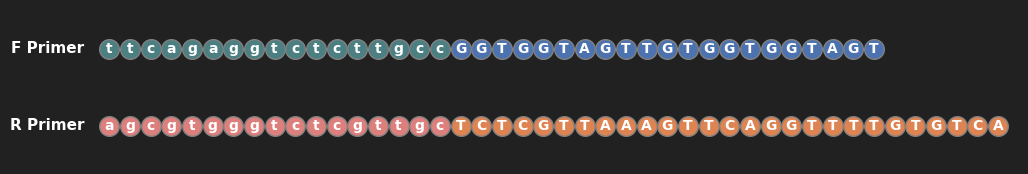

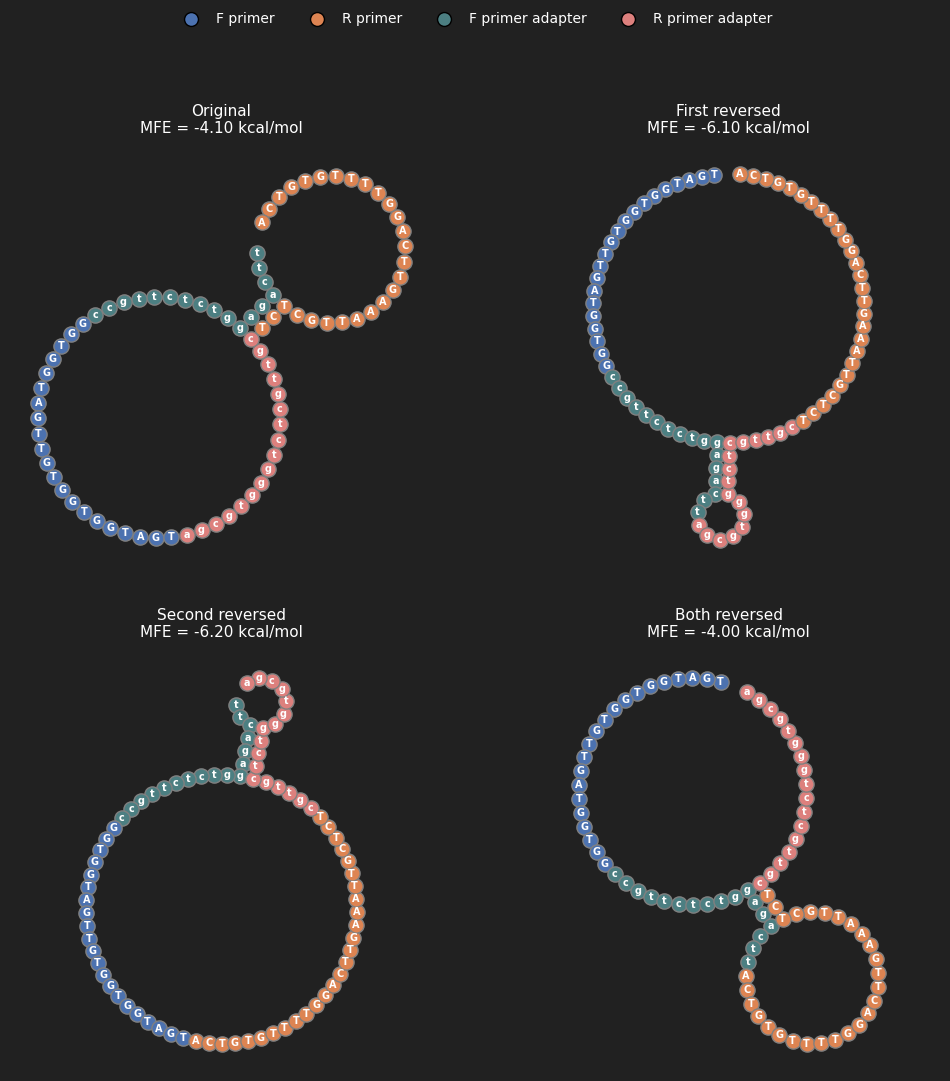

In [98]:
# Plot top primer pair
plot_linear(primer_pairs.iloc[0]['F_seq_adapted'], primer_pairs.iloc[0]['R_seq_adapted'])
plot_dimer(primer_pairs.iloc[0]['F_seq_adapted'], primer_pairs.iloc[0]['R_seq_adapted'])
#plot_dimer(primer_pairs.iloc[0]['F_seq_adapted'])
#plot_dimer(primer_pairs.iloc[0]['R_seq_adapted'])


In [99]:
# Score visualization for forward primers
scores_f = find_primers(seq, search_region=(1,None), adapter_seq=adapter_f_seq, id_str='fwd_', tm_threshold=53, CONSTRAINTS=None)
scores_r = find_primers(rev_seq, search_region=(1,60), adapter_seq=adapter_r_seq, id_str='rev_', tm_threshold=53, return_reverse_coordinates=True,CONSTRAINTS=None)


fwd_ Search sequence length: 3172
rev_ Search sequence length: 60


In [100]:
# Show score from both
score_column = 'Homodimer_MFE_adapted'
scoring_f = generate_score_vector(seq, scores_f, score_column="fwd_"+score_column, orientation="fwd")
scoring_r = generate_score_vector(rev_seq, scores_r, score_column="rev_"+score_column, orientation="rev")
score = overlay_scores(scoring_f, scoring_r)
# Overlay r scores onto f scores
# Visualize forward primers with
visualize_sequence_html(seq, annotations, scores=score, row_length=160, cmap_name="gist_stern", cmap_limits=(-20,-3.5), show_legend=True)
#visualize_sequence_html(seq, annotations, scores=score, row_length=140, cmap_name="hot", show_legend=True)
visualize_sequence_html(seq, annotations, scores=None, row_length=160, cmap_limits=None, show_legend=False)

In [ ]:
# Generate annotations based on promoter, cds and search regions
#annotations = get_annotations(len(promoter_seq), len(coding_seq))
#annotations = quick_annotation(annotations, "F primer", (235, 255), case="lower", bold=True)
#annotations = quick_annotation(annotations, "R primer", (4072,4092), case="lower", bold=True)
visualize_sequence_html(seq, annotations, scores=None, row_length=160)


In [21]:
import pandas as pd
import re


def analyze_primers_from_xlsx(
    input_xlsx,
    output_xlsx,
    name_col="name",
    number_col="number",
    primer_seq_col="sequence",
    id_prefix="fwd_"
):
    df = pd.read_excel(input_xlsx)

    results = []

    for _, row in df[[number_col, name_col, primer_seq_col]].dropna().iterrows():
        primer_number = row[number_col]
        primer_name = row[name_col]
        primer_sequence = str(row[primer_seq_col])

        primer_seq = "".join(re.findall(r"[A-Z]+", primer_sequence))
        adapter_seq = "".join(re.findall(r"[a-z]+", primer_sequence))

        primer_id = f"{id_prefix}{primer_number}"

        res_df = analyze_primer(
            primer_seq,
            adapter_seq=adapter_seq,
            id_str=primer_id
        )

        # Normalize column names
        res_df = res_df.rename(
            columns=lambda c: c.replace(primer_id, "")
        )

        # Attach metadata
        res_df.insert(0, "primer_id", primer_id)
        res_df.insert(1, number_col, primer_number)
        res_df.insert(2, name_col, primer_name)
        res_df.insert(3, primer_seq_col, primer_sequence)

        results.append(res_df)
    if not results:
        raise ValueError("No primers were successfully analyzed.")
    
    final_df = pd.concat(results, ignore_index=True)
    final_df = final_df.round(2)
    final_df.to_excel(output_xlsx, index=False)

    return final_df
final_df = analyze_primers_from_xlsx(
    input_xlsx="primers.xlsx",
    output_xlsx="primer_analysis.xlsx",
    name_col="name",
    number_col="primer_number",
    primer_seq_col="sequence",
    id_prefix="fwd_")